![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# *Homework 3*

### Authors: **Tirdod Behbehani and Victor Sobottka** 

#### Class: **Big Data Management**

In [4]:
import pandas as pd 
import numpy as np
import os
from pathlib import Path
import json

from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
import mlflow
import mlflow.spark
from pathlib import Path

In [5]:
# Initialize Spark
spark = SparkSession.builder.appName("B2_Model_Training").getOrCreate()

# Load dataset from exploitation zone
exploitation_zone = Path.cwd() / "exploitation_zone"

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/23 23:38:35 WARN Utils: Your hostname, FH15, resolves to a loopback address: 127.0.1.1; using 192.168.178.177 instead (on interface wlp0s20f3)
25/06/23 23:38:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/23 23:38:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/23 23:38:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [6]:
spark

In [7]:
# List all folders (and files) inside exploitation_zone
dir = [f.name for f in exploitation_zone.iterdir() if f.is_dir()]
print("Exploitation Zone Folders:")
for f in dir:
    print("-", f)

Exploitation Zone Folders:
- incident_top_type_by_district_year
- district_mapping
- income_weighted_avg_rfd_by_district_year
- unemployment_avg_by_district_year
- incident_peak_month_by_district_year
- incident_total_by_district_year
- income_avg_rfd_by_district_year
- income_above_below_avg_threshold
- unemployment_avg_by_district_gender_year
- unemployment_pct_change_by_district_year


In [9]:
from pathlib import Path

exploitation_zone = Path.cwd() / "exploitation_zone"

#load the district mapping dataset
district_mapping_df = spark.read.parquet(str(exploitation_zone / "district_mapping"))

# Load each KPI dataset
incident_total_df = spark.read.parquet(str(exploitation_zone / "incident_total_by_district_year"))
incident_top_type_df = spark.read.parquet(str(exploitation_zone / "incident_top_type_by_district_year"))
incident_peak_month_df = spark.read.parquet(str(exploitation_zone / "incident_peak_month_by_district_year"))

income_avg_df = spark.read.parquet(str(exploitation_zone / "income_avg_rfd_by_district_year"))
income_above_below_df = spark.read.parquet(str(exploitation_zone / "income_above_below_avg_threshold"))
income_weighted_df = spark.read.parquet(str(exploitation_zone / "income_weighted_avg_rfd_by_district_year"))

unemp_by_gender_df = spark.read.parquet(str(exploitation_zone / "unemployment_avg_by_district_gender_year"))
unemp_by_district_df = spark.read.parquet(str(exploitation_zone / "unemployment_avg_by_district_year"))
unemp_pct_change_df = spark.read.parquet(str(exploitation_zone / "unemployment_pct_change_by_district_year"))

# List of DataFrames with names for printing
dfs = [
    ("district_mapping", district_mapping_df),
    ("incident_total_by_district_year", incident_total_df),
    ("incident_top_type_by_district_year", incident_top_type_df),
    ("incident_peak_month_by_district_year", incident_peak_month_df),
    ("income_avg_rfd_by_district_year", income_avg_df),
    ("income_above_below_avg_threshold", income_above_below_df),
    ("income_weighted_avg_rfd_by_district_year", income_weighted_df),
    ("unemployment_avg_by_district_gender_year", unemp_by_gender_df),
    ("unemployment_avg_by_district_year", unemp_by_district_df),
    ("unemployment_pct_change_by_district_year", unemp_pct_change_df),
]

# Print schema for each
for name, df in dfs:
    print(f"\n=== Schema: {name} ===")
    df.printSchema()
    df.show(25, truncate=False)


=== Schema: district_mapping ===
root
 |-- District_Code: integer (nullable = true)
 |-- District_Name: string (nullable = true)

+-------------+-------------------+
|District_Code|District_Name      |
+-------------+-------------------+
|2            |Eixample           |
|1            |Ciutat Vella       |
|9            |Sant Andreu        |
|3            |Sants-Montjuïc     |
|4            |Les Corts          |
|5            |Sarrià-Sant Gervasi|
|8            |Nou Barris         |
|7            |Horta-Guinardó     |
|10           |Sant Martí         |
|6            |Gràcia             |
|-1           |Unknown            |
|99           |City-Wide          |
+-------------+-------------------+


=== Schema: incident_total_by_district_year ===
root
 |-- District_Code: integer (nullable = true)
 |-- Creation_Year: integer (nullable = true)
 |-- total_incidences: long (nullable = true)

+-------------+-------------+----------------+
|District_Code|Creation_Year|total_incidences|
+----

Model 1: We will create  logistic regression model that classifies districts as low income or high income. We will determine high income as above 100 RFD and low income as below 100 RFD.

before we model, let's engineer some features

In [10]:
from pyspark.ml.feature import StringIndexer

# Index top incident type
incident_top_indexed = StringIndexer(inputCol="Details", outputCol="incident_type_index")
incident_top_type_df_indexed = incident_top_indexed.fit(incident_top_type_df).transform(incident_top_type_df)

# Keep only needed columns
incident_top_features_df = incident_top_type_df_indexed.select("District_Code", "Creation_Year", "incident_type_index") \
    .withColumnRenamed("Creation_Year", "Year")

In [11]:
unemp_gender_pivot = unemp_by_gender_df.groupBy("District_Code", "Year").pivot("Gender").avg("avg_unemployment_rate_by_gender_year")

# Rename columns for clarity
unemp_gender_features_df = unemp_gender_pivot.withColumnRenamed("Homes", "unemp_homes") \
                                             .withColumnRenamed("Dones", "unemp_dones")

# Compute gender unemployment gap
from pyspark.sql.functions import col

unemp_gender_features_df = unemp_gender_features_df.withColumn(
    "gender_unemp_gap", col("unemp_homes") - col("unemp_dones")
)

In [12]:
from pyspark.sql.functions import avg

# Average unemployment pct change per year
unemp_pct_features_df = unemp_pct_change_df.groupBy("District_Code", "Year") \
    .agg(avg("pct_change").alias("avg_pct_change"))

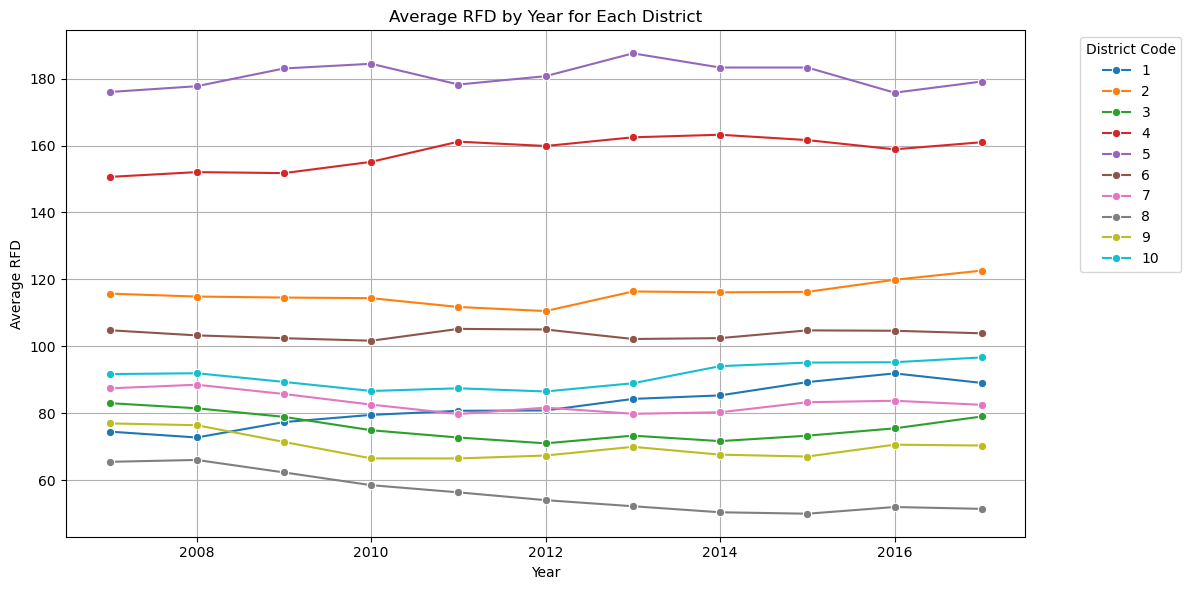

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Collect income data to Pandas
income_pd = income_avg_df.toPandas()

# Step 2: Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=income_pd,
    x="Year",
    y="avg_RFD",
    hue="District_Code",
    palette="tab10",
    marker="o"
)

plt.title("Average RFD by Year for Each District")
plt.xlabel("Year")
plt.ylabel("Average RFD")
plt.legend(title="District Code", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

In [14]:
from pyspark.sql.functions import when

income_labeled_df = income_avg_df.withColumn(
    "high_income", when(income_avg_df["avg_RFD"] >= 100, 1).otherwise(0)
)

In [15]:
features_df = income_labeled_df \
    .join(incident_total_df.withColumnRenamed("Creation_Year", "Year"), on=["District_Code", "Year"], how="left") \
    .join(unemp_by_district_df, on=["District_Code", "Year"], how="left") \
    .join(income_weighted_df, on=["District_Code", "Year"], how="left") 

In [16]:
features_df.show(25, truncate=False)

+-------------+----+------------------+-----------+----------------+---------------------------------------+-----------------------+
|District_Code|Year|avg_RFD           |high_income|total_incidences|avg_unemployment_rate_per_district_year|population_weighted_RFD|
+-------------+----+------------------+-----------+----------------+---------------------------------------+-----------------------+
|8            |2012|54.046153435340294|0          |NULL            |598.4615384615385                      |57.094206237391326     |
|10           |2008|91.97000045776367 |0          |NULL            |NULL                                   |87.47673893633159      |
|8            |2013|52.23076893733098 |0          |NULL            |625.8461538461538                      |56.17614001063652      |
|10           |2009|89.3800006866455  |0          |NULL            |NULL                                   |83.65777461096015      |
|8            |2007|65.5              |0          |NULL            |N

In [17]:
from pyspark.sql.functions import col, avg, when

# --- incident_top_type_by_district_year: Convert top type to numeric index
from pyspark.ml.feature import StringIndexer

incident_indexer = StringIndexer(
    inputCol="Details", 
    outputCol="incident_type_index", 
    handleInvalid="keep"
)
incident_indexed_df = incident_indexer.fit(incident_top_type_df).transform(incident_top_type_df)
incident_type_agg_df = incident_indexed_df.groupBy("District_Code", "Creation_Year") \
    .agg(avg("incident_type_index").alias("incident_type_index")) \
    .withColumnRenamed("Creation_Year", "Year")

# --- unemployment_avg_by_district_gender_year: Compute gender unemployment gap
unemp_pivot_df = unemp_by_gender_df.groupBy("District_Code", "Year") \
    .pivot("Gender") \
    .agg(avg("avg_unemployment_rate_by_gender_year"))

gender_gap_df = unemp_pivot_df.withColumn(
    "gender_unemp_gap", col("Homes") - col("Dones")
)

# --- unemployment_pct_change_by_district_year: Average yearly change
unemp_pct_change_agg = unemp_pct_change_df.groupBy("District_Code", "Year") \
    .agg(avg("pct_change").alias("avg_pct_change"))

In [18]:
features_df = income_labeled_df \
    .join(incident_total_df.withColumnRenamed("Creation_Year", "Year"), on=["District_Code", "Year"], how="left") \
    .join(unemp_by_district_df, on=["District_Code", "Year"], how="left") \
    .join(income_weighted_df, on=["District_Code", "Year"], how="left") \
    .join(incident_type_agg_df, on=["District_Code", "Year"], how="left") \
    .join(gender_gap_df.select("District_Code", "Year", "gender_unemp_gap"), on=["District_Code", "Year"], how="left") \
    .join(unemp_pct_change_agg, on=["District_Code", "Year"], how="left")

In [19]:
features_df.show(25, truncate=False)

+-------------+----+------------------+-----------+----------------+---------------------------------------+-----------------------+-------------------+-------------------+------------------+
|District_Code|Year|avg_RFD           |high_income|total_incidences|avg_unemployment_rate_per_district_year|population_weighted_RFD|incident_type_index|gender_unemp_gap   |avg_pct_change    |
+-------------+----+------------------+-----------+----------------+---------------------------------------+-----------------------+-------------------+-------------------+------------------+
|8            |2012|54.046153435340294|0          |NULL            |598.4615384615385                      |57.094206237391326     |NULL               |NULL               |151.71538461538464|
|10           |2008|91.97000045776367 |0          |NULL            |NULL                                   |87.47673893633159      |NULL               |NULL               |NULL              |
|8            |2013|52.23076893733098 |0

In [20]:
essential_features = [
    "total_incidences",
    "avg_unemployment_rate_per_district_year"
]

optional_features = [
    "incident_type_index",
    "gender_unemp_gap",
    "avg_pct_change"
]

model_df = features_df.select(
    "high_income", *(essential_features)
).dropna(subset=essential_features)

In [21]:
from pyspark.sql.functions import col

# Step 1: Define features
essential_features = [
    "total_incidences",
    "avg_unemployment_rate_per_district_year"
]

optional_features = [
    "incident_type_index",
    "gender_unemp_gap",
    "avg_pct_change"
]

# Step 2: Select only rows without missing essential features
model_df = features_df.select("high_income", *(essential_features + optional_features)) \
                      .dropna(subset=essential_features)

# Step 3: Compute medians for optional features
median_dict = {}
for col_name in optional_features:
    median_value = model_df.approxQuantile(col_name, [0.5], 0.001)[0]
    median_dict[col_name] = median_value

# Step 4: Fill missing optional features with medians
model_df_filled = model_df.fillna(median_dict)

# Step 5: Assemble feature vector
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=essential_features + optional_features,
    outputCol="features"
)

assembled_df = assembler.transform(model_df_filled).select("features", "high_income")

In [22]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Fit the logistic regression model
from pyspark.ml.classification import LogisticRegression

# Split into training and test sets
train_df, test_df = assembled_df.randomSplit([0.8, 0.2], seed=42)

# Define logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="high_income")

# Train the model
lr_model = lr.fit(train_df)

# Make predictions
predictions = lr_model.transform(test_df)

# Evaluate using ROC AUC
evaluator = BinaryClassificationEvaluator(labelCol="high_income", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print(f"ROC AUC on test set: {roc_auc:.4f}")

ROC AUC on test set: 0.5556


**Model 2: Random Forest Classifier with Cross-Validation & Full Evaluation**

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


# Step 1: Split into training/test sets
train_df, test_df = assembled_df.randomSplit([0.8, 0.2], seed=42)

# Step 2: Initialize Random Forest
rf = RandomForestClassifier(labelCol="high_income", featuresCol="features", seed=42)

# Step 3: Hyperparameter grid for tuning
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .build()

# Step 4: Evaluator (binary classification)
binary_evaluator = BinaryClassificationEvaluator(labelCol="high_income", metricName="areaUnderROC")

# Step 5: CrossValidator setup
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=param_grid,
                    evaluator=binary_evaluator,
                    numFolds=5,
                    parallelism=2,  # speed up if multi-core available
                    seed=42)

# Step 6: Fit model
cv_model = cv.fit(train_df)

# Step 7: Best model
best_rf_model = cv_model.bestModel

# Step 8: Predict on test set
predictions = best_rf_model.transform(test_df)
predictions.select("prediction", "probability", "high_income").show(10, truncate=False)


25/06/23 23:46:41 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 19 (= number of training instances)
25/06/23 23:46:41 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 64 to 19 (= number of training instances)
25/06/23 23:46:43 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 64 to 19 (= number of training instances)
25/06/23 23:46:43 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 19 (= number of training instances)
25/06/23 23:46:43 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 19 (= number of training instances)
25/06/23 23:46:44 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 64 to 19 (= number of training instances)
25/06/23 23:46:44 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 19 (= number of training instances)
25/06/23 23:46:45 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 64 to 19 (= number of training instances)
25/06/23 23:46:45 WARN D

+----------+-----------+-----------+
|prediction|probability|high_income|
+----------+-----------+-----------+
|0.0       |[0.6,0.4]  |0          |
|0.0       |[0.64,0.36]|0          |
|1.0       |[0.38,0.62]|1          |
|0.0       |[0.9,0.1]  |1          |
|0.0       |[0.78,0.22]|0          |
|0.0       |[0.58,0.42]|1          |
+----------+-----------+-----------+



**Evaluation Metrics**

In [24]:
# Binary evaluation
roc_auc = binary_evaluator.evaluate(predictions)
print(f"ROC AUC (test): {roc_auc:.4f}")

# Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="high_income", metricName="accuracy")
acc = accuracy_evaluator.evaluate(predictions)
print(f"Accuracy: {acc:.4f}")

# Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="high_income", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
print(f"Precision: {precision:.4f}")

# Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="high_income", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)
print(f"Recall: {recall:.4f}")

# F1 Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="high_income", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)
print(f"F1 Score: {f1_score:.4f}")


ROC AUC (test): 0.6667
Accuracy: 0.6667
Precision: 0.8000
Recall: 0.6667
F1 Score: 0.6250


**Feature Importance**

In [25]:
# Get feature importances
import pandas as pd

feature_importances = best_rf_model.featureImportances
feature_names = essential_features + optional_features

# Pair feature names with importances
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": feature_importances.toArray()
}).sort_values("importance", ascending=False)

print("\nTop Features by Importance:")
print(importance_df)



Top Features by Importance:
                                   feature  importance
4                           avg_pct_change    0.316334
2                      incident_type_index    0.229592
1  avg_unemployment_rate_per_district_year    0.229290
0                         total_incidences    0.174372
3                         gender_unemp_gap    0.050412
